In [1]:
!pip install tensorflow_decision_forests
!pip install tf_keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 28.5 MB/s eta 0:00:00


In [5]:
import os
#Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow_decision_forests as tfdf
import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import math

In [6]:
# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_excel("Data-RF.xlsx")
# Display the first 3 examples.
dataset_df.head(3)

,Lab-Test1(30),Lab-Test2(24),Midsem Test (90),Gender,Attendance,Grade
0,13.00,24,66.0,Male,High,A
1,15.00,24,67.0,Female,High,A
2,5.25,24,45.0,Male,High,B-


**Encode the categorical labels as integers.**

In [7]:
# Details:
# This stage is necessary if your classification label is represented as a # string since Keras expects integer classification labels. #When using pd_dataframe_to_tf_dataset (see below), this step can be skipped.
# Name of the label column.
#label = "Grade"
#classes = dataset_df[label].unique().tolist()
#print(f"Label classes: {classes}")
#dataset_df[label] = dataset_df[label].map(classes.index)

**70 - 30 Split (337-163)**

In [59]:
# Split the dataset into a training and a testing dataset.
def split_dataset (dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset [~test_indices], dataset[test_indices]
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format( len(train_ds_pd), len(test_ds_pd)))

337 examples in training, 163 examples for testing.


##Training accuracy for 10 DTs (CART)

In [129]:
model_1 = tfdf.keras.RandomForestModel(verbose=2, categorical_algorithm = "CART", num_trees=10, max_depth=16)
# Train the model.
train_ds= tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="Grade")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label="Grade")
model_1.fit(train_ds)

Use 2 thread(s) for training
Use /tmp/tmptqennpwc as temporary training directory


Reading training dataset...
Training tensor examples:
Features: {'Lab-Test1(30)': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Lab-Test2(24)': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'Midsem_Test_(90)': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Gender': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'Attendance': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>}
Label: Tensor("data_5:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'Lab-Test1(30)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'Lab-Test2(24)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'Midsem_Test_(90)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Gender': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_3:0' shape=(None,) dtype=string>), 'Atten

[INFO 24-02-12 16:03:06.6113 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-02-12 16:03:06.6113 UTC kernel.cc:772] Collect training examples
[INFO 24-02-12 16:03:06.6114 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-02-12 16:03:06.6115 UTC kernel.cc:391] Number of batches: 1
[INFO 24-02-12 16:03:06.6115 UTC kernel.cc:392] Number of examples: 337
[INFO 24-02-12 16:03:06.6116 UTC data_spec_inference.cc:305] 2 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Gender (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 24-02-12 16:03:06.6117 UTC kernel.cc:792] Tra

Model trained in 0:00:00.079344
Compiling model...
Model compiled.


###Plot for training accuracy of 10 trees

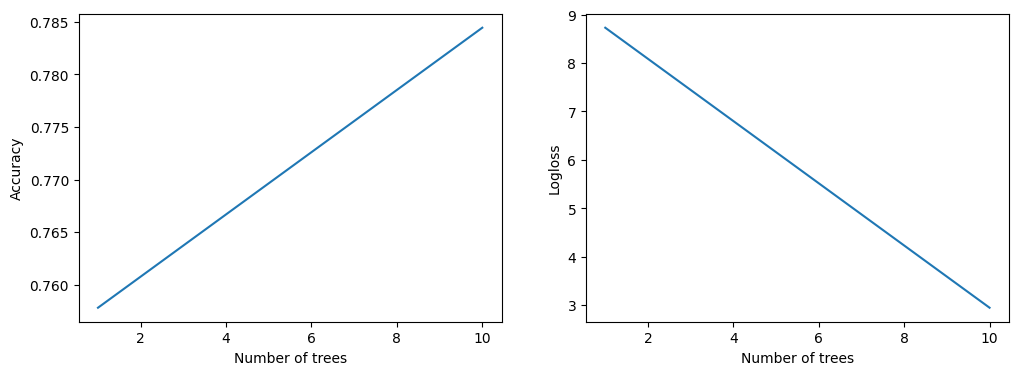

In [130]:
import matplotlib.pyplot as plt
logs = model_1.make_inspector().training_logs()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation. loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")
plt.show()

###Testing accuracy for 10 DTs (CART)

In [131]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()
for name, value in evaluation.items():
  print(f"{name}: {value:.8f}")

1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - accuracy: 0.8282

loss: 0.00000000
accuracy: 0.82822084


###Plot of Individual DTs (index 0)

In [132]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

###Plot of Individual DTs (index 1)

In [133]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=1, max_depth=3)

##Training accuracy for 30 DTs (CART)

In [134]:
model_1 = tfdf.keras.RandomForestModel(verbose=2, categorical_algorithm="CART", num_trees=30, max_depth=16)
#Train the model.
model_1.fit(train_ds)

Use 2 thread(s) for training
Use /tmp/tmp4vuef3lc as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Lab-Test1(30)': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Lab-Test2(24)': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'Midsem_Test_(90)': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Gender': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'Attendance': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>}
Label: Tensor("data_5:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'Lab-Test1(30)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'Lab-Test2(24)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'Midsem_Test_(90)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Gender': SemanticTensor(semantic=<Semantic.

[INFO 24-02-12 16:03:28.5920 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-02-12 16:03:28.5921 UTC kernel.cc:772] Collect training examples
[INFO 24-02-12 16:03:28.5921 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-02-12 16:03:28.5922 UTC kernel.cc:391] Number of batches: 1
[INFO 24-02-12 16:03:28.5922 UTC kernel.cc:392] Number of examples: 337
[INFO 24-02-12 16:03:28.5923 UTC data_spec_inference.cc:305] 2 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Gender (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 24-02-12 16:03:28.5924 UTC kernel.cc:792] Tra

Model trained in 0:00:00.105412
Compiling model...
Model compiled.


Testing accuracy for 30 trees improved from that of 10 trees. (82.822084)

### Plot for training accuracy of 30 DTs

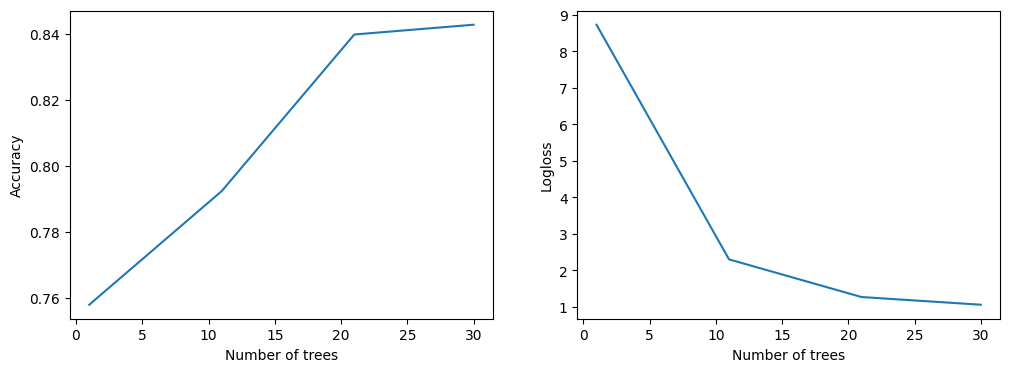

In [135]:
import matplotlib.pyplot as plt
logs = model_1.make_inspector().training_logs()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")
plt.show()

**Using number of trees = 169, max_depth =11. Accuracy = 86.6469** (see below)

In [136]:
model_1 = tfdf.keras.RandomForestModel(verbose=2, categorical_algorithm="CART", num_trees=169, max_depth=11)
#Train the model.
model_1.fit(train_ds)

Use 2 thread(s) for training
Use /tmp/tmp8p274qgu as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Lab-Test1(30)': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Lab-Test2(24)': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'Midsem_Test_(90)': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Gender': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'Attendance': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>}
Label: Tensor("data_5:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'Lab-Test1(30)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'Lab-Test2(24)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'Midsem_Test_(90)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Gender': SemanticTensor(semantic=<Semantic.

[INFO 24-02-12 16:03:41.3733 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-02-12 16:03:41.3734 UTC kernel.cc:772] Collect training examples
[INFO 24-02-12 16:03:41.3734 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-02-12 16:03:41.3735 UTC kernel.cc:391] Number of batches: 1
[INFO 24-02-12 16:03:41.3735 UTC kernel.cc:392] Number of examples: 337
[INFO 24-02-12 16:03:41.3736 UTC data_spec_inference.cc:305] 2 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Gender (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 24-02-12 16:03:41.3737 UTC kernel.cc:792] Tra

Model trained in 0:00:00.255972
Compiling model...
Model compiled.


## Checking if increasing num_trees hyper-parameter leads to more robust and accurate trees.

###*num_trees = 100*

In [137]:
model_1 = tfdf.keras.RandomForestModel(verbose=2, categorical_algorithm="CART", num_trees=100, max_depth=11)
#Train the model.
model_1.fit(train_ds)

Use 2 thread(s) for training
Use /tmp/tmpa0l_ni_f as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Lab-Test1(30)': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Lab-Test2(24)': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'Midsem_Test_(90)': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Gender': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'Attendance': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>}
Label: Tensor("data_5:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'Lab-Test1(30)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'Lab-Test2(24)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'Midsem_Test_(90)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Gender': SemanticTensor(semantic=<Semantic.

[INFO 24-02-12 16:03:51.8093 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-02-12 16:03:51.8094 UTC kernel.cc:772] Collect training examples
[INFO 24-02-12 16:03:51.8094 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-02-12 16:03:51.8095 UTC kernel.cc:391] Number of batches: 1
[INFO 24-02-12 16:03:51.8095 UTC kernel.cc:392] Number of examples: 337
[INFO 24-02-12 16:03:51.8096 UTC data_spec_inference.cc:305] 2 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Gender (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 24-02-12 16:03:51.8097 UTC kernel.cc:792] Tra

Model trained in 0:00:00.142610
Compiling model...
Model compiled.


**For num_trees = 100, Accuracy = 85.4599 %, which is greater than for 30 trees, but less than for 169 trees**

### *num_trees = 200*

In [138]:
model_1 = tfdf.keras.RandomForestModel(verbose=2, categorical_algorithm="CART", num_trees=200, max_depth=11)
#Train the model.
model_1.fit(train_ds)

Use 2 thread(s) for training
Use /tmp/tmpi7rkrpiq as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Lab-Test1(30)': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Lab-Test2(24)': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'Midsem_Test_(90)': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Gender': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'Attendance': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>}
Label: Tensor("data_5:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'Lab-Test1(30)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'Lab-Test2(24)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'Midsem_Test_(90)': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Gender': SemanticTensor(semantic=<Semantic.

[INFO 24-02-12 16:04:02.2672 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-02-12 16:04:02.2672 UTC kernel.cc:772] Collect training examples
[INFO 24-02-12 16:04:02.2672 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-02-12 16:04:02.2674 UTC kernel.cc:391] Number of batches: 1
[INFO 24-02-12 16:04:02.2674 UTC kernel.cc:392] Number of examples: 337
[INFO 24-02-12 16:04:02.2675 UTC data_spec_inference.cc:305] 2 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Gender (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 24-02-12 16:04:02.2676 UTC kernel.cc:792] Tra

Model trained in 0:00:00.280007
Compiling model...
Model compiled.


**For num_trees = 200, Accuracy = 86.6469 %, which is exactly equal to that of 169 trees, which means that the performance of the model stagnates at 169 trees.**

##Visualising Hypothesis space of the dataset by using scatterplot

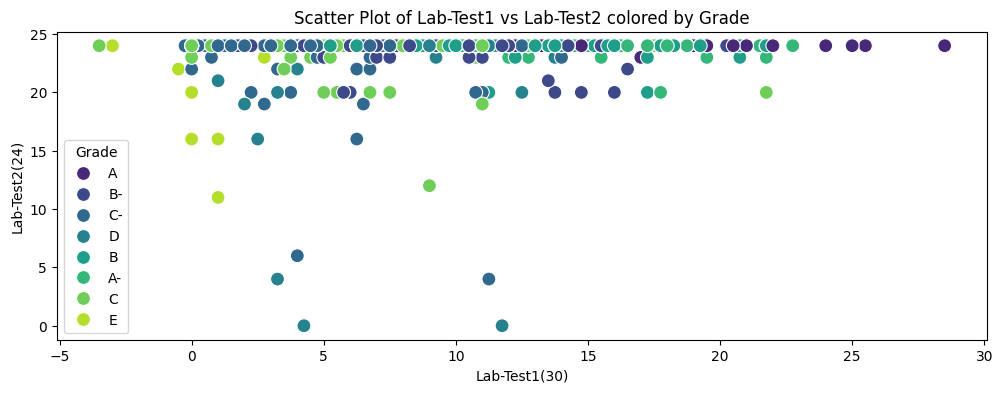

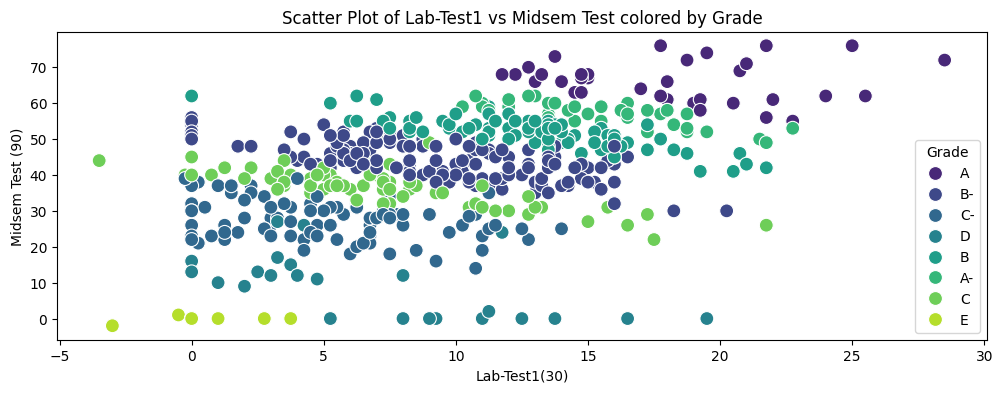

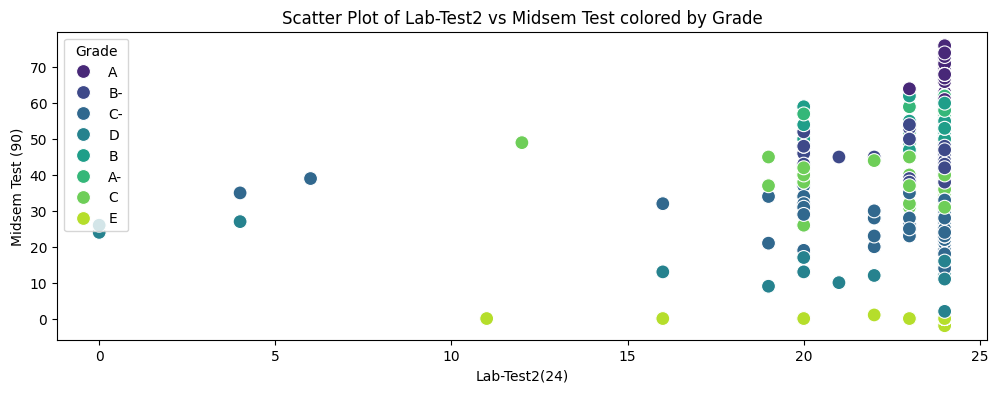

In [38]:
import seaborn as sns
plt.figure(figsize=(12, 4))
sns.scatterplot(x='Lab-Test1(30)', y='Lab-Test2(24)', hue='Grade', data=dataset_df, palette='viridis', edgecolor='w', s=100)
plt.title('Scatter Plot of Lab-Test1 vs Lab-Test2 colored by Grade')
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(x='Lab-Test1(30)', y='Midsem Test (90)', hue='Grade', data=dataset_df, palette='viridis', edgecolor='w', s=100)
plt.title('Scatter Plot of Lab-Test1 vs Midsem Test colored by Grade')
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(x='Lab-Test2(24)', y='Midsem Test (90)', hue='Grade', data=dataset_df, palette='viridis', edgecolor='w', s=100)
plt.title('Scatter Plot of Lab-Test2 vs Midsem Test colored by Grade')
plt.show()

##Gradient Boosted Decision Tree (GBDT)

In [139]:
# Create the GBDT model
model_2 = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION)
model_2.fit(train_ds)
model_2.compile(metrics=["accuracy"])
evaluation_gbdt = model_2.evaluate(test_ds, return_dict=True)
# Print the results for GBDT
print("\nGradient Boosted Decision Tree Model:")
for name, value in evaluation_gbdt.items():
    print(f"{name}: {value:.8f}")


Use /tmp/tmpomkgmfln as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.184808. Found 337 examples.
Training model...
Model trained in 0:00:00.352331
Compiling model...
Model compiled.
1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - accuracy: 0.8528

Gradient Boosted Decision Tree Model:
loss: 0.00000000
accuracy: 0.85276073


Accuracy for RF with 30 DT: 84.273 %<br>
Accuracy for GBDT: 85.276 %

## **Conclusion:<br> We have achieved a high accuracy of 86.6469 % using num_trees = 169 and max_depth = 11 for our random forest decision tree model.**